In [1]:
import tensorflow as tf
import numpy as np
import os
import time
import datetime
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
def plot(imgs, title=None):
    # make sure input is a list
    if not isinstance(imgs, list):
        imgs = [imgs]
    
    plt.figure()
        
    for i in range(len(imgs)):
        if(title is not None): 
            plt.suptitle(title)
        plt.subplot(1, len(imgs), i+1)
        plt.axis("off")
        # fix channels for rgb
        if len(imgs[i].shape) > 2:
            plt.imshow(imgs[i][:,:,[2,1,0]])
        else:
            plt.imshow(imgs[i])

In [3]:
config = {}
# Get from dataset.
config['num_test_samples'] = 2174
config['num_validation_samples'] = 1765
config['num_training_samples'] = 5722

config['batch_size'] = 16
config['learning_rate'] = 1e-3
# Learning rate is annealed exponentally in 'exponential' case. Don't forget to change annealing configuration in the code.
#config['learning_rate_type'] = 'fixed' #'exponential'
config['learning_rate_type'] = 'exponential'

config['num_steps_per_epoch'] = int(config['num_training_samples']/config['batch_size'])

config['num_epochs'] = 1000
config['evaluate_every_step'] = config['num_steps_per_epoch']*5
config['checkpoint_every_step'] = config['num_steps_per_epoch']*30
config['num_validation_steps'] = int(config['num_validation_samples']/config['batch_size'])
config['print_every_step'] = config['num_steps_per_epoch']
config['log_dir'] = './runs/'

config['img_height'] = 80
config['img_width'] = 80
config['img_num_channels'] = 3
config['skeleton_size'] = 180

# CNN model parameters
config['cnn'] = {}
config['cnn']['cnn_filters'] = [16,32,64,128] # Number of filters for every convolutional layer.
config['cnn']['num_hidden_units'] = 512 # Number of output units, i.e. representation size.
config['cnn']['dropout_rate'] = 0.5
config['cnn']['initializer'] = tf.contrib.layers.xavier_initializer()
# RNN model parameters
config['rnn'] = {}
config['rnn']['num_hidden_units'] = 512 # Number of units in an LSTM cell.
config['rnn']['num_layers'] = 3 # Number of LSTM stack.
config['rnn']['num_class_labels'] = 20
config['rnn']['initializer'] = tf.contrib.layers.xavier_initializer()
config['rnn']['batch_size'] = config['batch_size']
config['rnn']['loss_type'] = 'average' # or 'last_step' # In the case of 'average', average of all time-steps is used instead of the last time-step.

config['ip_queue_capacity'] = config['batch_size']*50
config['ip_num_read_threads'] = 6

config['train_data_dir'] = "/home/nico/git/uieproject/data/train"
config['train_file_format'] = "dataTrain_%d.tfrecords"
config['train_file_ids'] = list(range(1,41))
config['valid_data_dir'] = "/home/nico/git/uieproject/data/validation"
config['valid_file_format'] = "dataValidation_%d.tfrecords"
config['valid_file_ids'] = list(range(1,16))


# Create a unique output directory for this experiment.
timestamp = str(int(time.time()))
model_name = 'LR(%.3f)-LRType(%s)-RNNLayers(%i)-%s' % (config['learning_rate'], config['learning_rate_type'], config['rnn']['num_layers'], timestamp)
config['model_dir'] = os.path.abspath(os.path.join(config['log_dir'], model_name))
print("Writing to {}\n".format(config['model_dir']))

Writing to /home/nico/git/uieproject/sample_code/runs/LR(0.001)-LRType(exponential)-RNNLayers(3)-1497392040



In [4]:
def read_and_decode_sequence(filename_queue, config):
    # Create a TFRecordReader.
    readerOptions = tf.python_io.TFRecordOptions(compression_type=tf.python_io.TFRecordCompressionType.GZIP)
    reader = tf.TFRecordReader(options=readerOptions)
    _, serialized_example = reader.read(filename_queue)
    
    # Read one sequence sample.
    # The training and validation files contains the following fields:
    # - label: label of the sequence which take values between 1 and 20.
    # - length: length of the sequence, i.e., number of frames.
    # - depth: sequence of depth images. [length x height x width x numChannels]
    # - rgb: sequence of rgb images. [length x height x width x numChannels]
    # - segmentation: sequence of segmentation maskes. [length x height x width x numChannels]
    # - skeleton: sequence of flattened skeleton joint positions. [length x numJoints]
    #
    # The test files doesn't contain "label" field.
    # [height, width, numChannels] = [80, 80, 3]
    with tf.name_scope("TFRecordDecoding"):
        context_encoded, sequence_encoded = tf.parse_single_sequence_example(
                serialized_example,
                # "label" and "lenght" are encoded as context features. 
                context_features={
                    "label": tf.FixedLenFeature([], dtype=tf.int64),
                    "length": tf.FixedLenFeature([], dtype=tf.int64)
                },
                # "depth", "rgb", "segmentation", "skeleton" are encoded as sequence features.
                sequence_features={
                    "depth": tf.FixedLenSequenceFeature([], dtype=tf.string),
                    "rgb": tf.FixedLenSequenceFeature([], dtype=tf.string),
                    "segmentation": tf.FixedLenSequenceFeature([], dtype=tf.string),
                    "skeleton": tf.FixedLenSequenceFeature([], dtype=tf.string),
                })

        
        # Fetch required data fields. 
        # TODO: Customize for your design. Assume that only the RGB images are used for now.
        # Decode the serialized RGB images.    
        seq_rgb = tf.decode_raw(sequence_encoded['rgb'], tf.uint8)
        seq_seg = tf.decode_raw(sequence_encoded['segmentation'], tf.uint8)
        seq_dep = tf.decode_raw(sequence_encoded['depth'], tf.uint8)
        
        # Output dimensionality: [seq_len, height, width, numChannels]
        
        # tf.map_fn applies the preprocessing function to every image in the sequence, i.e., frame.
        seq_rgb = tf.map_fn(lambda x: preprocessing_op(x, config),
                                elems=(seq_rgb,seq_seg,seq_dep),
                                dtype=tf.float32,
                                back_prop=False)
        
        seq_label = context_encoded['label']
        
        # Tensorflow requires the labels start from 0. Before you create submission csv, 
        # increment the predictions by 1.
        seq_label = seq_label - 1
        seq_len = tf.to_int32(context_encoded['length'])
        
        """
        # Use skeleton only.
        seq_skeleton = tf.decode_raw(sequence_encoded['skeleton'], tf.float32)
        # Normalize skeleton so that every pose is a unit length vector.
        seq_skeleton = tf.nn.l2_normalize(seq_skeleton, dim=1)
        seq_skeleton.set_shape([None, config['skeleton_size']])
        
        seq_len = tf.to_int32(context_encoded['length'])
        seq_label = context_encoded['label']
        # Tensorflow requires the labels start from 0. Before you create submission csv, 
        # increment the predictions by 1.
        seq_label = seq_label - 1
        """
        
        return [seq_rgb, seq_label, seq_len]
    

def input_pipeline(filenames, config, name='input_pipeline', shuffle=True):
    with tf.name_scope(name):
        # Create a queue of TFRecord input files.
        filename_queue = tf.train.string_input_producer(filenames, num_epochs=config['num_epochs'], shuffle=shuffle)
        # Read the data from TFRecord files, decode and create a list of data samples by using threads.
        sample_list = [read_and_decode_sequence(filename_queue, config) for _ in range(config['ip_num_read_threads'])]
        # Create batches.
        # Since the data consists of variable-length sequences, allow padding by setting dynamic_pad parameter.
        # "batch_join" creates batches of samples and pads the sequences w.r.t the max-length sequence in the batch.
        # Hence, the padded sequence length can be different for different batches.
        batch_rgb, batch_labels, batch_lens = tf.train.batch_join(sample_list,
                                                    batch_size=config['batch_size'],
                                                    capacity=config['ip_queue_capacity'],
                                                    enqueue_many=False,
                                                    dynamic_pad=True,
                                                    allow_smaller_final_batch = False,
                                                    name="batch_join_and_pad")

        return batch_rgb, batch_labels, batch_lens

In [5]:
def preprocessing_op(frame, config):
    """
    Creates preprocessing operations that are going to be applied on a single frame.
    
    TODO: Customize for your needs.
    You can do any preprocessing (masking, normalization/scaling of inputs, augmentation, etc.) by using tensorflow operations.
    Built-in image operations: https://www.tensorflow.org/api_docs/python/tf/image 
    """
    with tf.name_scope("preprocessing"):
        rgb = frame[0]
        seg = frame[1]
        dep = frame[2]
        
        # Reshape serialized image.
        rgb = tf.reshape(rgb, (config['img_height'], 
                               config['img_width'], 
                               config['img_num_channels'])
                        )
        
        seg = tf.reshape(seg, (config['img_height'], 
                               config['img_width'], 
                               config['img_num_channels'])
                        )
        
        dep = tf.reshape(dep, (config['img_height'], 
                               config['img_width'], 
                               1)
                        )
        
        # Convert from RGB to grayscale.
        rgb = tf.image.rgb_to_grayscale(rgb)
        seg = tf.image.rgb_to_grayscale(seg)
        dep = tf.image.rgb_to_grayscale(dep)
        
        # Integer to float.
        rgb = tf.to_float(rgb)
        dep = tf.to_float(dep)
        
        seg = tf.greater(seg, 150)
        
        rgb = tf.where(seg, rgb, tf.zeros_like(rgb))
        dep = tf.where(seg, dep, tf.zeros_like(rgb))
        
        # Crop
        #image_op = tf.image.resize_image_with_crop_or_pad(image_op, 60, 60)
        
        # Resize operation requires 4D tensors (i.e., batch of images).
        # Reshape the image so that it looks like a batch of one sample: [1,60,60,1]
        #image_op = tf.expand_dims(image_op, 0)
        # Resize
        #image_op = tf.image.resize_bilinear(image_op, np.asarray([32,32]))
        # Reshape the image: [32,32,1]
        #image_op = tf.squeeze(image_op, 0)
        
        # Normalize (zero-mean unit-variance) the image locally, i.e., by using statistics of the 
        # image not the whole data or sequence.
        
        rgb = tf.image.per_image_standardization(rgb)
        dep = tf.image.per_image_standardization(dep)
        
        rgb = tf.squeeze(rgb)
        dep = tf.squeeze(dep)
        
        # Flatten image
        #image_op = tf.reshape(image_op, [-1])
    
        return tf.stack([rgb, dep], axis=-1)

In [6]:
class CNNModel():
    """
    Creates training and validation computational graphs.
    Note that tf.variable_scope enables sharing the parameters so that both graphs share the parameters.
    """
    def __init__(self, config, input_op, mode):
        """
        Basic setup.
        Args:
          config: Object containing configuration parameters.
        """
        assert mode in ["training", "validation"]
        self.config = config
        self.inputs = input_op
        self.mode = mode
        self.is_training = self.mode == "training"
        self.reuse = self.mode == "validation"
        
        
    def build_model(self, input_layer):
        with tf.variable_scope("cnn_model", reuse=self.reuse, initializer=self.config['initializer']):
            # Convolutional Layer #1
            # Computes 32 features using a 3x3 filter with ReLU activation.
            # Padding is added to preserve width and height.
            # Input Tensor Shape: [batch_size, 80, 80, num_channels]
            # Output Tensor Shape: [batch_size, 40, 40, num_filter1]
            conv1 = tf.layers.conv2d(
                inputs=input_layer,
                filters=self.config['cnn_filters'][0],
                kernel_size=[3, 3],
                padding="same",
                activation=tf.nn.relu)

            pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2, padding='same')

            # Input Tensor Shape: [batch_size, 40, 40, num_filter1]
            # Output Tensor Shape: [batch_size, 20, 20, num_filter2]
            conv2 = tf.layers.conv2d(
                inputs=pool1,
                filters=self.config['cnn_filters'][1],
                kernel_size=[5, 5],
                padding="same",
                activation=tf.nn.relu)

            pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2, padding='same')

            # Input Tensor Shape: [batch_size, 20, 20, num_filter2]
            # Output Tensor Shape: [batch_size, 10, 10, num_filter3]
            conv3 = tf.layers.conv2d(
                inputs=pool2,
                filters=self.config['cnn_filters'][2],
                kernel_size=[3, 3],
                padding="same",
                activation=tf.nn.relu)

            pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=[2, 2], strides=2, padding='same')

            # Input Tensor Shape: [batch_size, 10, 10, num_filter3]
            # Output Tensor Shape: [batch_size, 5, 5, num_filter4]
            conv4 = tf.layers.conv2d(
                inputs=pool3,
                filters=self.config['cnn_filters'][3],
                kernel_size=[3, 3],
                padding="same",
                activation=tf.nn.relu)

            pool4 = tf.layers.max_pooling2d(inputs=conv4, pool_size=[2, 2], strides=2, padding='same')


            # Flatten tensor into a batch of vectors
            # Input Tensor Shape: [batch_size, 5, 5, num_filter4]
            # Output Tensor Shape: [batch_size, 5 * 5 * num_filter4]
            conv_flat = tf.reshape(pool4, [-1, 5 * 5 * self.config['cnn_filters'][3]])

            # Add dropout operation;
            dropout = tf.layers.dropout(inputs=conv_flat, rate=self.config['dropout_rate'], training=self.is_training)

            # Dense Layer
            # Densely connected layer with <num_hidden_units> neurons
            # Input Tensor Shape: [batch_size, 5 * 5 * num_filter4]
            # Output Tensor Shape: [batch_size, num_hidden_units]
            dense = tf.layers.dense(inputs=dropout, units=self.config['num_hidden_units'],
                activation=tf.nn.relu)
        
            self.cnn_model = dense
            return dense
            
    def build_graph(self):
        """
        CNNs accept inputs of shape (batch_size, height, width, num_channels). However, we have inputs of shape
        (batch_size, sequence_length, height, width, num_channels) where sequence_length is inferred at run time.
        We need to iterate in order to get CNN representations. Similar to python's map function, "tf.map_fn" 
        applies a given function on each entry in the input list. 
        """
        # For the first time create a dummy graph and then share the parameters everytime.
        if self.is_training:
            self.reuse = False
            self.build_model(self.inputs[0])
            self.reuse = True
        
        # CNN takes a clip as if it is a batch of samples.
        # Have a look at tf.map_fn (https://www.tensorflow.org/api_docs/python/tf/map_fn)
        # You can set parallel_iterations or swap_memory in order to make it faster.
        # Note that back_prop argument is True in order to enable training of CNN.
        self.cnn_representations = tf.map_fn(lambda x: self.build_model(x),
                                                elems=self.inputs,
                                                dtype=tf.float32,
                                                back_prop=True,
                                                swap_memory=True,
                                                parallel_iterations=2)
        
        return self.cnn_representations
        

class RNNModel():
    """
    Creates training and validation computational graphs.
    Note that tf.variable_scope enables sharing the parameters so that both graphs share the parameters.
    """
    def __init__(self, config, input_op, target_op, seq_len_op, mode):
        """
        Basic setup.
        Args:
          config: Object containing configuration parameters.
        """
        assert mode in ["training", "validation"]
        self.config = config
        self.inputs = input_op
        self.targets = target_op
        self.seq_lengths = seq_len_op
        self.mode = mode
        self.reuse = self.mode == "validation"
        
    def build_rnn_model(self):
        with tf.variable_scope('rnn_cell', reuse=self.reuse, initializer=self.config['initializer']):
            rnn_cell = tf.contrib.rnn.BasicLSTMCell(num_units=self.config['num_hidden_units'])
        with tf.variable_scope('rnn_stack', reuse=self.reuse, initializer=self.config['initializer']):
            if self.config['num_layers'] > 1:
                rnn_cell = tf.contrib.rnn.MultiRNNCell([rnn_cell for _ in range(self.config['num_layers'])])
            self.model_rnn, self.rnn_state = tf.nn.dynamic_rnn(
                                            cell=rnn_cell,
                                            inputs=self.inputs,
                                            dtype = tf.float32,
                                            sequence_length=self.seq_lengths,
                                            time_major=False,
                                            swap_memory=True)
            # Fetch output of the last step.
            if self.config['loss_type'] == 'last_step':
                self.rnn_prediction = tf.gather_nd(self.model_rnn, tf.stack([tf.range(self.config['batch_size']), self.seq_lengths-1], axis=1))
            elif self.config['loss_type'] == 'average':
                self.rnn_prediction = self.model_rnn
            else:
                print("Invalid loss type")
                raise
                
    
    def build_model(self):
        self.build_rnn_model()
        # Calculate logits
        with tf.variable_scope('logits', reuse=self.reuse, initializer=self.config['initializer']):
            self.logits = tf.layers.dense(inputs=self.rnn_prediction, units=self.config['num_class_labels'],
                                            kernel_initializer = tf.contrib.layers.xavier_initializer(),
                                            bias_initializer=tf.contrib.layers.xavier_initializer())
            
            # In the case of average loss, take average of time steps in order to calculate
            # final prediction probabilities.
            if self.config['loss_type'] == 'average':
                self.logits = tf.reduce_mean(self.logits, axis=1)
            
    def loss(self):
        # Loss calculations: cross-entropy
        with tf.name_scope("cross_entropy_loss"):
            self.loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=self.logits, labels=self.targets))
            
                # Accuracy calculations.
        with tf.name_scope("accuracy"):
            # Return list of predictions (useful for making a submission)
            self.predictions = tf.argmax(self.logits, 1, name="predictions")
            # Return a bool tensor with shape [batch_size] that is true for the
            # correct predictions.
            self.correct_predictions = tf.equal(tf.argmax(self.logits, 1), self.targets)
            # Number of correct predictions in order to calculate average accuracy afterwards.
            self.num_correct_predictions = tf.reduce_sum(tf.cast(self.correct_predictions, tf.int32))
            # Calculate the accuracy per minibatch.
            self.batch_accuracy = tf.reduce_mean(tf.cast(self.correct_predictions, tf.float32))
        
    def build_graph(self):
        self.build_model()
        self.loss()
        self.num_parameters()
        
        return self.logits, self.loss, self.batch_accuracy, self.predictions
    
    def num_parameters(self):
        self.num_parameters = 0
        #iterating over all variables
        for variable in tf.trainable_variables():
            local_parameters=1
            shape = variable.get_shape()  #getting shape of a variable
            for i in shape:
                local_parameters*=i.value  #mutiplying dimension values
            self.num_parameters+=local_parameters
print('Done')

Done


In [7]:
# Create a list of tfRecord input files.
train_filenames = [os.path.join(config['train_data_dir'], config['train_file_format'] % i) for i in config['train_file_ids']]
# Create data loading operators. This will be represented as a node in the computational graph.
train_batch_samples_op, train_batch_labels_op, train_batch_seq_len_op = input_pipeline(train_filenames, config, name='training_input_pipeline')

print(train_batch_samples_op.shape)

# Create a list of tfRecord input files.
valid_filenames = [os.path.join(config['valid_data_dir'], config['valid_file_format'] % i) for i in config['valid_file_ids']]
# Create data loading operators. This will be represented as a node in the computational graph.
valid_batch_samples_op, valid_batch_labels_op, valid_batch_seq_len_op = input_pipeline(valid_filenames, config, name='validation_input_pipeline', shuffle=False)

# Create placeholders for training and monitoring variables.
loss_avg_op = tf.placeholder(tf.float32, name="loss_avg")
accuracy_avg_op = tf.placeholder(tf.float32, name="accuracy_avg")

# Generate a variable to contain a counter for the global training step.
# Note that it is useful if you save/restore your network.
global_step = tf.Variable(1, name='global_step', trainable=False)

# Create seperate graphs for training and validation.
# Training graph
# Note that our model is optimized by using the training graph.
with tf.name_scope("Training"):
    # Create model
    cnnModel = CNNModel(config=config['cnn'],
                        input_op=train_batch_samples_op, 
                        mode='training')
    cnn_representations = cnnModel.build_graph()
    
    trainModel = RNNModel(config=config['rnn'], 
                            input_op=cnn_representations, 
                            target_op=train_batch_labels_op, 
                            seq_len_op=train_batch_seq_len_op,
                            mode="training")
    trainModel.build_graph()
    print("\n# of parameters: %s" % trainModel.num_parameters)
    
    # Optimization routine.
    # Learning rate is decayed in time. This enables our model using higher learning rates in the beginning.
    # In time the learning rate is decayed so that gradients don't explode and training staurates.
    # If you observe slow training, feel free to modify decay_steps and decay_rate arguments.
    if config['learning_rate_type'] == 'exponential':
        learning_rate = tf.train.exponential_decay(config['learning_rate'], 
                                                   global_step=global_step,
                                                   decay_steps=1000, 
                                                   decay_rate=0.97,
                                                   staircase=False)
    elif config['learning_rate_type'] == 'fixed':
        learning_rate = config['learning_rate']
    else:
        print("Invalid learning rate type")
        raise
        
    optimizer = tf.train.AdamOptimizer(learning_rate)
    train_op = optimizer.minimize(trainModel.loss, global_step=global_step)

# Validation graph.
with tf.name_scope("Evaluation"):
    # Create model
    validCnnModel = CNNModel(config=config['cnn'],
                                input_op=valid_batch_samples_op, 
                                mode='validation')
    valid_cnn_representations = validCnnModel.build_graph()
    
    validModel = RNNModel(config=config['rnn'], 
                            input_op=valid_cnn_representations, 
                            target_op=valid_batch_labels_op, 
                            seq_len_op=valid_batch_seq_len_op,
                            mode="validation")
    validModel.build_graph()

    
# Create summary ops for monitoring the training.
# Each summary op annotates a node in the computational graph and collects
# data data from it.
summary_train_loss = tf.summary.scalar('loss', trainModel.loss)
summary_train_acc = tf.summary.scalar('accuracy_training', trainModel.batch_accuracy)
summary_avg_accuracy = tf.summary.scalar('accuracy_avg', accuracy_avg_op)
summary_avg_loss = tf.summary.scalar('loss_avg', loss_avg_op)
summary_learning_rate = tf.summary.scalar('learning_rate', learning_rate)

# Group summaries.
# summaries_training is used during training and reported after every step.
summaries_training = tf.summary.merge([summary_train_loss, summary_train_acc, summary_learning_rate])
# summaries_evaluation is used by both trainig and validation in order to report the performance on the dataset.
summaries_evaluation = tf.summary.merge([summary_avg_accuracy, summary_avg_loss])
    
#Create session object
sess = tf.Session()
# Add the ops to initialize variables.
init_op = tf.group(tf.global_variables_initializer(),tf.local_variables_initializer())
# Actually intialize the variables
sess.run(init_op)

# Register summary ops.
train_summary_dir = os.path.join(config['model_dir'], "summary", "train")
train_summary_writer = tf.summary.FileWriter(train_summary_dir, sess.graph)
valid_summary_dir = os.path.join(config['model_dir'], "summary", "validation")
valid_summary_writer = tf.summary.FileWriter(valid_summary_dir, sess.graph)

# Create a saver for writing training checkpoints.
saver = tf.train.Saver(max_to_keep=3)

# Define counters in order to accumulate measurements.
counter_correct_predictions_training = 0.0
counter_loss_training = 0.0
counter_correct_predictions_validation = 0.0
counter_loss_validation = 0.0

coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(sess=sess, coord=coord)
print('Done')

(16, ?, 80, 80, 2)

# of parameters: 8052260
Done


In [ ]:
# Training Loop
try:
    while not coord.should_stop():
        step = tf.train.global_step(sess, global_step)
            
        if (step%config['checkpoint_every_step']) == 0:
            ckpt_save_path = saver.save(sess, os.path.join(config['model_dir'], 'model'), global_step)
            print("Model saved in file: %s" % ckpt_save_path)
            
        # Run the optimizer to update weights.
        # Note that "train_op" is responsible from updating network weights.
        # Only the operations that are fed are evaluated.
        # Run the optimizer to update weights.
        train_summary, num_correct_predictions, loss, _ = sess.run([summaries_training, 
                                                                      trainModel.num_correct_predictions, 
                                                                      trainModel.loss, 
                                                                      train_op], 
                                                                      feed_dict={})
        # Update counters.
        counter_correct_predictions_training += num_correct_predictions
        counter_loss_training += loss
        # Write summary data.
        train_summary_writer.add_summary(train_summary, step)
        
        # Report training performance
        if (step%config['print_every_step']) == 0:
            accuracy_avg = counter_correct_predictions_training / (config['batch_size']*config['print_every_step'])
            loss_avg = counter_loss_training / (config['print_every_step'])
            summary_report = sess.run(summaries_evaluation, feed_dict={accuracy_avg_op:accuracy_avg, loss_avg_op:loss_avg})
            train_summary_writer.add_summary(summary_report, step)
            print("[%d/%d] [Training] Accuracy: %.3f, Loss: %.3f" % (step/config['num_steps_per_epoch'], 
                                                                     step, 
                                                                     accuracy_avg, 
                                                                     loss_avg))
            
            counter_correct_predictions_training = 0.0
            counter_loss_training= 0.0
        
        if (step%config['evaluate_every_step']) == 0:
            # It is possible to create only one input pipelene queue. Hence, we create a validation queue 
            # in the begining for multiple epochs and control it via a foor loop.
            # Note that we only approximate 1 validation epoch (validation doesn't have to be accurate.)
            # In other words, number of unique validation samples may differ everytime.
            for eval_step in range(config['num_validation_steps']):
                # Calculate average validation accuracy.
                num_correct_predictions, loss = sess.run([validModel.num_correct_predictions, 
                                                          validModel.loss],
                                                         feed_dict={})
                # Update counters.
                counter_correct_predictions_validation += num_correct_predictions
                counter_loss_validation += loss
            
            # Report validation performance
            accuracy_avg = counter_correct_predictions_validation / (config['batch_size']*config['num_validation_steps'])
            loss_avg = counter_loss_validation / (config['num_validation_steps'])
            summary_report = sess.run(summaries_evaluation, feed_dict={accuracy_avg_op:accuracy_avg, loss_avg_op:loss_avg})
            valid_summary_writer.add_summary(summary_report, step)
            print("[%d/%d] [Validation] Accuracy: %.3f, Loss: %.3f" % (step/config['num_steps_per_epoch'], 
                                                                       step, 
                                                                       accuracy_avg, 
                                                                       loss_avg))
            
            counter_correct_predictions_validation = 0.0
            counter_loss_validation= 0.0
        
except tf.errors.OutOfRangeError:
    print('Model is trained for %d epochs, %d steps.' % (config['num_epochs'], step))
    print('Done.')
finally:
    # When done, ask the threads to stop.
    coord.request_stop()

# Wait for threads to finish.
coord.join(threads)

ckpt_save_path = saver.save(sess, os.path.join(config['model_dir'], 'model'), global_step)
print("Model saved in file: %s" % ckpt_save_path)
sess.close()

(16, ?, 80, 80, 2)
# Samples: 16
Sequence lengths: [63 88 60 84 82 76 98 71 63 54 59 58 61 81 59 70]
Sequence labels: [ 3 11 19 11 18 14 13  4 13 19 10  9  1 16  2  1]
Sequence type: <class 'numpy.ndarray'>
Sequence shape: (16, 98, 80, 80, 2)


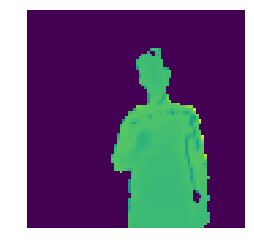

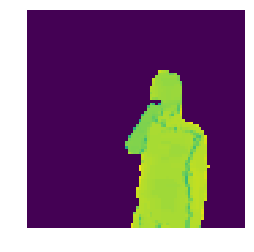

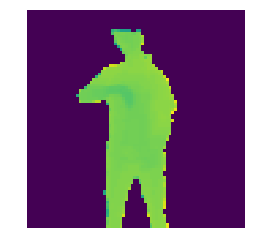

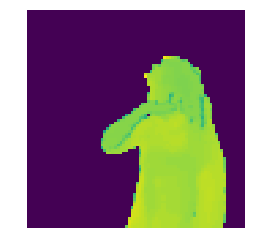

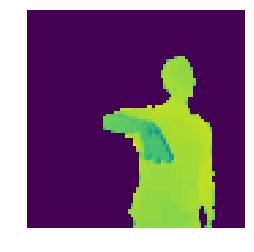

In [8]:
'''
A simple sanity check for input pipeline:
'''
def test_input_loader():
    config = {}
    config['img_height'] = 80
    config['img_width'] = 80
    config['img_num_channels'] = 3
    config['num_epochs'] = 10
    config['batch_size'] = 16
    # Capacity of the queue which contains the samples read by data readers.
    # Make sure that it has enough capacity.
    config['ip_queue_capacity'] = config['batch_size']*10  
    config['ip_num_read_threads'] = 6
    # Directory of the data.
    config['data_dir'] = "/home/nico/git/uieproject/data/train"
    # File naming
    config['file_format'] = "dataTrain_%d.tfrecords"
    # File IDs to be used
    config['file_ids'] = list(range(1,10))
    
    # Create a list of TFRecord input files.
    filenames = [os.path.join(config['data_dir'], config['file_format'] % i) for i in config['file_ids']]

    # Create data loading operators. This will be represented as a node in the computational graph.
    batch_samples_op, batch_labels_op, batch_seq_len_op = input_pipeline(filenames, config)
    
    print(batch_samples_op.shape)
    # TODO: batch_samples_op, batch_labels_op and batch_seq_len_op are like input placeholders. You can directly 
    # feed them to your model.

    # Create tensorflow session and initialize the variables (if any).
    sess = tf.Session()
    init_op = tf.group(tf.global_variables_initializer(),tf.local_variables_initializer())
    sess.run(init_op)
    # Create threads to prefetch the data.
    # https://www.tensorflow.org/programmers_guide/reading_data#creating_threads_to_prefetch_using_queuerunner_objects
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    
    batch_samples, batch_labels, batch_seq_len = sess.run([batch_samples_op, batch_labels_op, batch_seq_len_op])
    
    # Print 
    print("# Samples: " + str(len(batch_samples)))
    print("Sequence lengths: " + str(batch_seq_len))
    print("Sequence labels: " + str(batch_labels))
    
    # Note that the second dimension will give maximum-length in the batch, i.e., the padded sequence length.
    print("Sequence type: " + str(type(batch_samples)))
    print("Sequence shape: " + str(batch_samples.shape))

    # plot some
    plot(batch_samples[0][10][...,1].squeeze())
    plot(batch_samples[1][20][...,1].squeeze())
    plot(batch_samples[2][30][...,1].squeeze())
    plot(batch_samples[3][15][...,1].squeeze())
    plot(batch_samples[4][50][...,1].squeeze())
    
test_input_loader()